In [1]:
import cv2
import numpy as np
import os
from tensorflow.keras.applications import EfficientNetV2B0,MobileNetV2
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, TimeDistributed,LSTM, Dropout,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import img_to_array, load_img,ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt


In [2]:
import seaborn as sns

In [3]:
def extract_frames(file_path, num_frames=60):
    # Check if it's an image or video
    _, file_extension = os.path.splitext(file_path)

    if file_extension.lower() in ['.jpg', '.jpeg', '.png']:  # Assuming image format
        frame = cv2.imread(file_path)
        frame = cv2.resize(frame, (224, 224))
        preprocessed_frame = preprocess_frame(frame)
        frames = [preprocessed_frame] * num_frames  # Repeat the frame to get num_frames

    else:  # Assuming video format
        cap = cv2.VideoCapture(file_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_interval = total_frames // num_frames if total_frames > num_frames else 1
        frames = []

        for i in range(num_frames):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * frame_interval)  # Set the position of the video file
            ret, frame = cap.read()
            if not ret:
                frames.append(frames[-1])  # Repeat the last frame if no more frames in the video
            else:
                frame = cv2.resize(frame, (224, 224))
                preprocessed_frame = preprocess_frame(frame)
                frames.append(preprocessed_frame)

        cap.release()
    return frames

def preprocess_frame(frame):
    preprocessed_frame = preprocess_input(img_to_array(frame))
    skin_mask = extract_skin_mask(frame)
    blood_mask = extract_blood_mask(frame)
    preprocessed_frame = np.concatenate([preprocessed_frame], axis=-1)
    return preprocessed_frame

def extract_skin_mask(frame):
    # Convert the frame to the HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for skin color in HSV
    lower_skin = np.array([0, 20, 70], dtype="uint8")
    upper_skin = np.array([20, 255, 255], dtype="uint8")

    # Create a binary mask for the skin region
    skin_mask = cv2.inRange(hsv, lower_skin, upper_skin)

    # Apply morphological operations to smooth the mask
    skin_mask = cv2.erode(skin_mask, None, iterations=2)
    skin_mask = cv2.dilate(skin_mask, None, iterations=2)

    return skin_mask

def extract_blood_mask(frame):
    # Convert the frame to the HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for blood color in HSV
    lower_blood = np.array([0, 100, 100], dtype="uint8")
    upper_blood = np.array([10, 255, 255], dtype="uint8")

    # Create a binary mask for the blood region
    blood_mask = cv2.inRange(hsv, lower_blood, upper_blood)

    # Apply morphological operations to smooth the mask
    blood_mask = cv2.erode(blood_mask, None, iterations=2)
    blood_mask = cv2.dilate(blood_mask, None, iterations=2)

    return blood_mask

def load_video_data(data_dir):
    video_data = []
    labels = []

    # Assuming your data is organized in subdirectories for each class (explicit and non-explicit)
    classes = os.listdir(data_dir)

    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)

        for video_file in os.listdir(class_path):
            video_path = os.path.join(class_path, video_file)

            frames = extract_frames(video_path)
            video_data.append(frames)

            # Assign label based on class_name (e.g., 'explicit' or 'non_explicit')
            label = 1 if class_name.lower() == 'explicit' else 0
            labels.append(label)

    return video_data, labels

In [4]:
#load model
model = load_model('explicit_content_classifier_video2.h5')

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 60, 7, 7, 1280)   5919312   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 60, 62720)        0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 60, 128)           32178688  
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [ ]:
#generate classification report
from sklearn.metrics import classification_report
X_test, y_test = load_video_data('test')
# Convert lists to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

y_pred = model.predict(X_test)
# y_pred = np.argmax(y_pred, axis=1)
# y_test = np.argmax(y_test, axis=1)
print(classification_report(y_test, y_pred))




In [6]:

y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.88      0.78      0.82         9

    accuracy                           0.81        16
   macro avg       0.81      0.82      0.81        16
weighted avg       0.82      0.81      0.81        16



In [12]:
#predict with the model
def predict_video(video_path):
    frames = extract_frames(video_path)
    frames = np.expand_dims(frames, axis=0)
    y_pred = model.predict(frames)[0]
    return y_pred

#predict with the model
y_pred = predict_video('test/non-explicit/val1 (975).jpg')
print(y_pred)

[0.9859542]


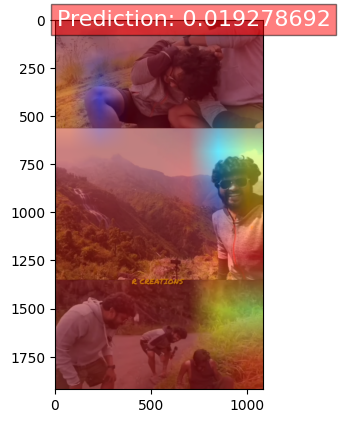

In [18]:
def extract_frames(file_path, num_frames=60):
    # Check if it's an image or video
    _, file_extension = os.path.splitext(file_path)

    original_frames = []
    preprocessed_frames = []

    if file_extension.lower() in ['.jpg', '.jpeg', '.png']:  # Assuming image format
        frame = cv2.imread(file_path)
        original_frames.append(frame)  # Append the original frame
        frame = cv2.resize(frame, (224, 224))
        preprocessed_frame = preprocess_frame(frame)
        preprocessed_frames = [preprocessed_frame] * num_frames  # Repeat the preprocessed frame

    else:  # Assuming video format
        cap = cv2.VideoCapture(file_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_interval = total_frames // num_frames if total_frames > num_frames else 1

        for i in range(num_frames):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * frame_interval)  # Set the position of the video file
            ret, frame = cap.read()
            if not ret:
                preprocessed_frames.append(preprocessed_frames[-1])  # Repeat the last preprocessed frame
                original_frames.append(original_frames[-1])  # Repeat the last original frame
            else:
                original_frames.append(frame)  # Append the original frame
                frame = cv2.resize(frame, (224, 224))
                preprocessed_frame = preprocess_frame(frame)
                preprocessed_frames.append(preprocessed_frame)

        cap.release()
    return original_frames, preprocessed_frames

# Extract frames from the video
# Extract frames from the video
original_frames, preprocessed_frames = extract_frames('test/non-explicit/SaveInsta.App - 3248287038700970206_60537821003.mp4')

# Convert the preprocessed frames to an array
frames = np.array(preprocessed_frames)
frames = frames.reshape((-1, 60, 224, 224, 3))

# Select one original frame and one preprocessed frame
selected_original_frame = original_frames[0]
selected_frame = frames[0, 0, :, :, :]

# Use the model to predict the output of the video
output = model.predict(frames)

# Convert the output to a string
output_str = str(output[0][0])

# Create a model that will return these outputs, given the model input
activation_model = Model(inputs=model.input, outputs=[layer.output for layer in model.layers])

# Returns a list of Numpy arrays: one array per layer activation
activations = activation_model.predict(frames)

# Visualization of the first layer activation corresponding to the selected frame
first_layer_activation = activations[0][0, 0, :, :, 0]

# Normalize the activation
normalized_activation = cv2.normalize(first_layer_activation, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Apply the colormap
colored_activation = cv2.applyColorMap(normalized_activation, cv2.COLORMAP_JET)

# Resize the activation to match the size of the original frame
resized_activation = cv2.resize(colored_activation, (selected_original_frame.shape[1], selected_original_frame.shape[0]))

# Overlay the activation on the original frame
overlay = cv2.addWeighted(cv2.cvtColor(selected_original_frame, cv2.COLOR_BGR2RGB), 0.5, resized_activation, 0.5, 0)

# Display the overlay
plt.imshow(overlay)
plt.text(10, 30, 'Prediction: ' + output_str, color='white', fontsize=16, bbox=dict(facecolor='red', alpha=0.5))
plt.show()

In [6]:
print(classification_report(y_test, y_pred))


NameError: name 'y_pred' is not defined